In [1]:
#1#------------------------------------------------------------------------------------------------------------------------#
#                                        Импорт библиотек                                                                  #
#--------------------------------------------------------------------------------------------------------------------------#


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import random
import scipy.stats as st
import statsmodels as sm
import seaborn as sns
from tqdm import tqdm
import requests
import statistics
from plotly.offline import iplot, init_notebook_mode
import plotly as py
import plotly.graph_objs as go
import ipywidgets as wd
import plotly.figure_factory as ff
import plotly.express as px
py.offline.init_notebook_mode(connected=True)
from scipy import special
import time

import itertools


In [11]:
#2#------------------------------------------------------------------------------------------------------------------------#
#                                        Объявление функций                                                                #
#--------------------------------------------------------------------------------------------------------------------------#

def create_dataset(row, data):
    default = {'RUB': -1.0}
    i_Date = row['index']
    try: 
        i_Rate = data['rates'][i_Date]["RUB"]
    except:
        i_Rate = default["RUB"]

    return i_Rate




def first_difference(current):
    global previous

    result = (current["Rate"] - previous)/current["Rate"]
    previous = current["Rate"]
    return(result)




def best_fit_distribution(data, bins=200, ax=None):
        y, x = np.histogram(data, bins=bins, density=True)


        x = (x + np.roll(x, -1))[:-1] / 2.0


        DISTRIBUTIONS = [        
            st.alpha,#,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
            #st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
            #st.foldcauchy,st.foldnorm,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
            #st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
            #st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
            #st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,
            #st.laplace,st.levy,st.levy_l,st.levy_stable,
            #st.logistic,st.loggamma, st.loglaplace, st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
            st.nct,st.norm,#st.pareto, st.pearson3, st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
            #st.rayleigh,st.rice, st.recipinvgauss, st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
            st.uniform, st.johnsonsu, #st.vonmises, st.vonmises_line, st.wald, st.weibull_min, st.weibull_max, st.wrapcauchy
        ]

        best_distribution = st.norm
        best_params = (0.0, 1.0)
        best_sse = np.inf


        for distribution in tqdm(DISTRIBUTIONS):
            try:
                print(distribution)
                params = distribution.fit(data)

                arg = params[:-2]

                loc = params[-2]

                scale = params[-1]

                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)

                sse = np.sum(np.power(y - pdf, 2.0)) 

                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

            except Exception:
                pass

        return best_distribution.name, best_params
    
    
def make_pdf(dist, params, size=1000):
        """Generate distributions's Probability Distribution Function """

        # Separate parts of parameters
        arg = params[:-2]

        loc = params[-2]

        scale = params[-1]

        # Get sane start and end points of distribution
        start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
        end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

        # Build PDF and turn into pandas Series
        x = np.linspace(start, end, size)
        y = dist.pdf(x, loc=loc, scale=scale, *arg)
        pdf = pd.Series(y, x)

        print(pdf)
        return pdf

    
def your_distribution(data):
    orig_mean = statistics.mean(data)
    orig_var = statistics.stdev(data)
    print('Original parameters:','\nmean =',orig_mean,'\nvariance =',orig_var)
    
    print('\nYour parameters:')
    
    params = []
    
    mean = float(input('mean = '))
    variance = float(input('variance = '))
    additional_params = (input('additional_params = ')).split(',')
    
    if len(additional_params) == 0:
        
        params.append(mean)
        params.append(variance)
        
    else: #additional_params == '':#
        
        
        def listToString(s):   
            str1 = " " 
            return (str1.join(s)) 
       
        s = additional_params 
          

        for i in listToString(s):
            a = float(listToString(s))
           #a = float(float(i) for i in additional_params)
           #a = ast.literal_eval(i)
            params.insert(len(params),a)
           
        params.insert(0,mean)
        params.insert(1,variance)
        
        #for i in additional_params:
        #    a = float(i)
        #    params.insert(len(params),a)
        #    
        #params.insert(0,mean)
        #params.insert(1,variance)
        
            
                  
    name1 = dist_name_with_params_from_st
    name = freedom_is_choice.value 
    
    your_params = params
    your_distribution_name = name
    
    #print(your_distribution,your_params)
    return your_distribution_name,your_params
#make_pdf(your_distribution,your_params)
    #return (your_params,your_distribution)
    #print(your_params,your_distribution)


In [3]:
dist_name_with_params_from_st = getattr(st,freedom_is_choice.value)
dist_name_with_params_from_st

NameError: name 'freedom_is_choice' is not defined

In [4]:
#3#------------------------------------------------------------------------------------------------------------------------#
#                                        Объявление переменных                                                             #
#--------------------------------------------------------------------------------------------------------------------------#

start_date = None
end_date = None 

url = None
response = None
data = None
last_rate = None
days = None

parameters = []

mean = []
variance = []
data = pd.DataFrame()

dist_name_with_params_from_st = None

pdf_list = pd.DataFrame()

DISTRIBUTIONS = []
distributions_list = list([])
df_dist = pd.DataFrame()

#distrpd = pd.DataFrame(DISTRIBUTIONS, columns= ['Parameters'], index = range(len(DISTRIBUTIONS)))


choice = None
freedom_is_choice = None
percentile_level = None
container = None

progress = None


In [14]:
#4#------------------------------------------------------------------------------------------------------------------------#
#                                        Загрузка данных                                                                   #
#--------------------------------------------------------------------------------------------------------------------------#




    
l = [i.strftime("%Y-%m-%d") for i in pd.date_range(start=start_date, end=end_date, freq='D')]
df = pd.DataFrame(index=l, columns=["Rate"])
df.reset_index(inplace=True)
df['Rate'] = df.apply(lambda row: create_dataset(row, data), axis = 1)
df = df[df["Rate"] != -1]
previous  = df.iloc[0]["Rate"]



#5#------------------------------------------------------------------------------------------------------------------------#
#                                        Вычисление первой разницы                                                         #
#--------------------------------------------------------------------------------------------------------------------------#



df["First_difference"] = df.apply(lambda row: first_difference(row), axis = 1)

In [7]:
#6#------------------------------------------------------------------------------------------------------------------------#
#                                        Опция выбора                                                                      #
#--------------------------------------------------------------------------------------------------------------------------#


DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,
        st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform, st.johnsonsu,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]


distributions_list = list([
    'alpha','anglit','arcsine','beta','betaprime','bradford','burr','cauchy','chi','chi2','cosine',
    'dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk',
    'foldcauchy','foldnorm','genlogistic','genpareto','gennorm','genexpon',
    'genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r',
    'gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss',
    'invweibull','johnsonsb','johnsonsu','ksone','kstwobign',
    'laplace','levy','levy_l','levy_stable',
    'logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf',
    'nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal',
    'rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda',
    'uniform','johnsonsu','vonmises','vonmises_line','wald','weibull_min','weibull_max','wrapcauchy'
])

df_dist = pd.DataFrame(distributions_list, columns = ['NAMES'], index = range(len(distributions_list)))


#__________________________________________________________________________________________________________________________#
#If you wanna put your distribution, click the button, please
#__________________________________________________________________________________________________________________________#
choice = wd.ToggleButton(
    value=False,
    description='OK',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

#Choose the distribution from the list above, please
freedom_is_choice = wd.Dropdown(
    #value = 'norm',
    description = 'Your Choice',
    options = df_dist['NAMES'].unique().tolist()
)

#Choose the percentile level, please 
percentile_level = wd.FloatSlider(
    value = 90.0,
    min = 0,
    max = 100.0,
    step=0.1,
    description='Choose percentile level:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)


dist_name_with_params_from_st = getattr(st,freedom_is_choice.value)



#textbox1 = wd.Dropdown(
#    description = 'Parameters',
#    options = distrpd['Parameters'].unique().tolist(),
    #value = '<scipy.stats._continuous_distns.norm_gen object at 0x000001ECFF1F5648>'
#)


container = wd.HBox(children=[choice,freedom_is_choice,percentile_level])
container 


In [12]:
if choice.value == True:
    
    group_labels = ['First_difference']
    colors = ['rgb(5, 59, 72)']
    
    p = make_pdf(best_dist, your_params)
    
    fig = ff.create_distplot(p,group_labels, bin_size=.5,
                         curve_type='normal', # override default 'kde'
                         colors=colors
        )
    fig.update_layout(title_text='Distplot with Normal Distribution')
    fig.show()

NameError: name 'best_dist' is not defined

#для вычисления перцентиля необходимо достать значения, которые рассчитывает your_distribution, засунуть их в numpy 
# и посчитать перцентиль 
your_distribution()
grt = pd.DataFrame(your_distribution(),columns = ['ADS'], index = ['ASw'])
grt

percent = 23
p23=st.scoreatpercentile(your_distribution(),percent)
p23

Original parameters: 
mean = 0.0003478178824505545 
variance = 0.011675603482540839

Your parameters:
mean = 0.0003478178824505545
variance = 0.011675603482540839
additional_params = 
-0.026814    2.282721
-0.026759    2.307563
-0.026705    2.332624
-0.026651    2.357907
-0.026596    2.383412
-0.026542    2.409140
-0.026487    2.435094
-0.026433    2.461274
-0.026379    2.487681
-0.026324    2.514317
-0.026270    2.541183
-0.026216    2.568280
-0.026161    2.595611
-0.026107    2.623175
-0.026052    2.650974
-0.025998    2.679010
-0.025944    2.707283
-0.025889    2.735796
-0.025835    2.764548
-0.025781    2.793543
-0.025726    2.822780
-0.025672    2.852262
-0.025617    2.881989
-0.025563    2.911962
-0.025509    2.942184
-0.025454    2.972654
-0.025400    3.003375
-0.025346    3.034348
-0.025291    3.065573
-0.025237    3.097053
               ...   
 0.025932    3.097053
 0.025987    3.065573
 0.026041    3.034348
 0.026096    3.003375
 0.026150    2.972654
 0.026204    2.942184
 0

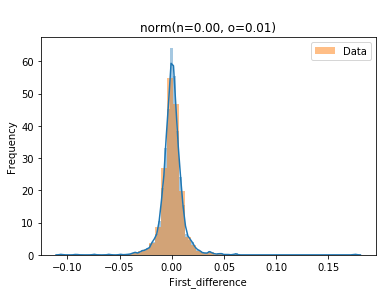

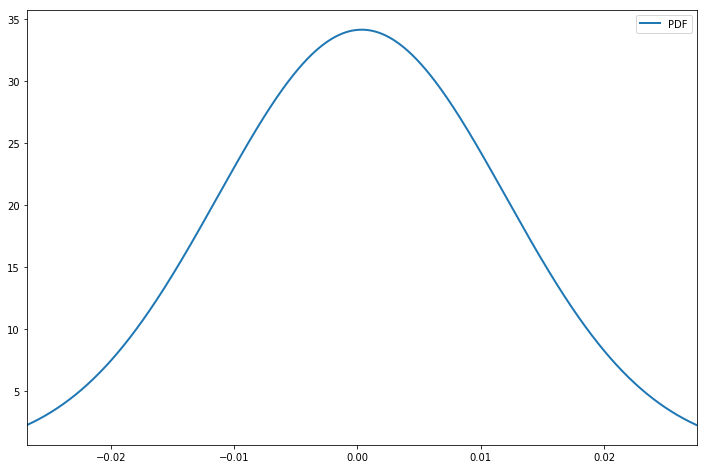

In [17]:
if choice.value == True:
    
    #best_distribution.name, best_params = your_distribution, your_params
    #your_distribution_name, your_params = your_distribution(data)
    
    #print(your_distribution(df['First_difference']))
    #make_pdf(your_distribution_name, your_params)
    
    data = df.First_difference
    ax = sns.distplot(df["First_difference"], bins = 100)
    your_distribution_name, your_params = your_distribution(data)   #best_fit_distribution(data, 200, ax)
    best_dist = getattr(st,freedom_is_choice.value)
    pdf = make_pdf(best_dist, your_params)
    plt.figure(figsize=(12,8))
    ax2 = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=50, alpha=0.5,  density = True, label='Data', legend=True, ax=ax)
    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(your_distribution_name, your_params)])
    dist_str = '{}({})'.format(your_distribution_name, param_str)
    ax.set_title(u'\n' + dist_str)
    
else:
    
    data = df.First_difference
    ax = sns.distplot(df["First_difference"], bins = 100)
    best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)   #best_fit_distribution(data, 200, ax)
    best_dist = getattr(st, best_fit_name)
    pdf = make_pdf(best_dist, best_fit_params)
    plt.figure(figsize=(12,8))
    ax2 = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=50, alpha=0.5,  density = True, label='Data', legend=True, ax=ax)
    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)
    ax.set_title(u'\n' + dist_str)
    #your_distribution()
#здесь должен быть график со всеми показателями - в том числе и перцентиль, который строим как отдельный график,
#и потом накладываем на график your_distribution
#все виджеты работают 
    
    
#else:
#здесь работает best_fit_distribution, которая сама подбирает как параметры, так и сама строит график     

In [18]:
x = np.array(pdf)
np.percentile(x, percentile_level.value)

18.76928645032056

In [19]:
statistics.median(x)

17.347951116128343

In [21]:
### def your_distribution(data_):
     
    trace = go.Histogram( x = data_, opacity = 0.75, name = 'Data distribution')
    data = [trace]
    graph = go.FigureWidget(data = [trace],
                       layout = go.Layout(title='Distribution of rates changes',
                        xaxis={'title':"Rates"},
                        yaxis={'title':'Frequency'}))
    #return graph
    

#if use_da.value:
#    your_distribution(df['First_difference'])
#
#else:
#    data = df.First_difference
#    ax = sns.distplot(df["First_difference"], bins = 100)
#    best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
#    best_fit_distribution(df['First_difference'], bins=200, ax=None)
#    best_dist = getattr(st, best_fit_name)
#    pdf = make_pdf(best_dist, best_fit_params)
#    plt.figure(figsize=(12,8))
#    ax2 = pdf.plot(lw=2, label='PDF', legend=True)
#    data.plot(kind='hist', bins=50, alpha=0.5,  density = True, label='Data', legend=True, ax=ax)
#    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
#    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
#    dist_str = '{}({})'.format(best_fit_name, param_str)
#    ax.set_title(u'\n' + dist_str)

IndentationError: unexpected indent (<ipython-input-21-47ce2640cbbf>, line 3)

fig = ff.create_distplot(hist_data = [df.First_difference.values.tolist()],
                        group_labels = [best_fit_name],
                        bin_size = [20000000])
iplot(fig)

trace = go.Histogram( x = df['First_difference'], opacity = 0.75, name ='Data distribution')
data = [trace]
graph = go.FigureWidget(data = [trace],
                       layout = go.Layout(title='Distribution of rates changes',
         xaxis={'title':"Rates"},
         yaxis={'title':'Frequency'}))
graph

In [30]:
last_rate = df.iloc[-1:,0:2]
last_rate

,index,Rate
2235,2020-02-14,63.55986


In [ ]:
df_dist = df_dist['NAMES'].apply(lambda row: row['PARAMETERS']),axis=1)

a = distributions_list
b = DISTRIBUTIONS
zipped = zip(a,b)
df_func = pd.DataFrame(zip(a,b), columns = ['NAME OF DIST','FUNC VIEW'], index = range(88))
df_func.reset_index(inplace=True)

days = wd.IntSlider(
    value = 1,
    min = 1,
    max = 365,
    step = 1,
    description = 'Days',
    continuous_update=False
)

#checking if all conditions are completed 
def checking ():
    df_func = pd.DataFrame(zip(a,b), columns = ['NAME OF DIST','FUNC VIEW'], index = range(88))
    df_func.reset_index(inplace=True)
    if textbox.value in df_func['NAME OF DIST'].unique() and textbox1.value in df_func['FUNC VIEW'].unique():
        return True
    else:
        return False 
#adjusting parameters of the graph    
def response(changes):
    if checking():
        if use_da.value:
            filter_list = [i and j for i,j in
                          zip(df_func['NAME OF DIST'] == textbox.value, df_func['FUNC VIEW'] == textbox1.value )]
            temp_df = df[filter_list]
        else:
            temp_df = [best_fit_distribution(data,bins=200,ax=None)]
    g = go.Histogram(x = temp_df)
    data = [g]
    
response(df)

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\ibratenkov001\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2316: RuntimeWarning:

invalid value encountered in double_scalars

 20%|██        | 1/5 [00:00<00:00,  9.11it/s]

 40%|████      | 2/5 [00:00<00:00,  6.19it/s]

100%|██████████| 5/5 [00:00<00:00,  6.71it/s]


-0.030911    0.839170
-0.030848    0.844671
-0.030786    0.850215
-0.030723    0.855803
-0.030660    0.861436
-0.030597    0.867112
-0.030535    0.872834
-0.030472    0.878602
-0.030409    0.884415
-0.030347    0.890274
-0.030284    0.896181
-0.030221    0.902134
-0.030158    0.908135
-0.030096    0.914184
-0.030033    0.920281
-0.029970    0.926428
-0.029907    0.932624
-0.029845    0.938869
-0.029782    0.945165
-0.029719    0.951512
-0.029657    0.957910
-0.029594    0.964360
-0.029531    0.970862
-0.029468    0.977417
-0.029406    0.984026
-0.029343    0.990688
-0.029280    0.997404
-0.029218    1.004175
-0.029155    1.011002
-0.029092    1.017884
               ...   
 0.029926    1.006544
 0.029988    0.999803
 0.030051    0.993117
 0.030114    0.986484
 0.030177    0.979904
 0.030239    0.973377
 0.030302    0.966902
 0.030365    0.960479
 0.030427    0.954107
 0.030490    0.947786
 0.030553    0.941515
 0.030616    0.935294
 0.030678    0.929122
 0.030741    0.923000
 0.030804 

Text(0.5, 1.0, '\njohnsonsu(a=-0.00, b=1.00, loc=0.00, scale=0.01)')

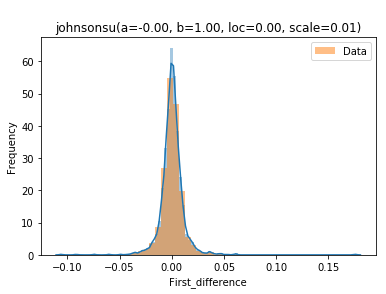

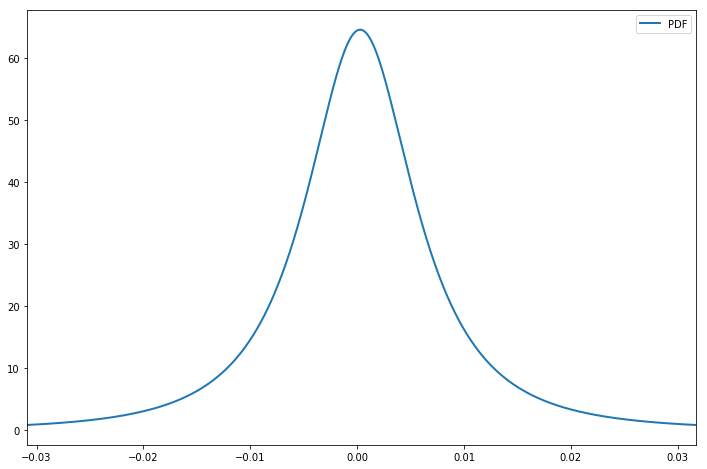

In [20]:
data = df.First_difference
ax = sns.distplot(df["First_difference"], bins = 100)
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)   #best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)
pdf = make_pdf(best_dist, best_fit_params)
plt.figure(figsize=(12,8))
ax2 = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, alpha=0.5,  density = True, label='Data', legend=True, ax=ax)
param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)
ax.set_title(u'\n' + dist_str)

In [ ]:
min(pdf)

In [23]:
pdf_list = pd.DataFrame(pdf)
pdf_list.reset_index(inplace=True)

In [24]:
pdf_list

,index,0
0,-0.030911,0.839170
1,-0.030848,0.844671
2,-0.030786,0.850215
3,-0.030723,0.855803
4,-0.030660,0.861436
5,-0.030597,0.867112
6,-0.030535,0.872834
7,-0.030472,0.878602
8,-0.030409,0.884415
9,-0.030347,0.890274


In [27]:
#Строится датафрейм из значений первой разницы, помноженных на их 1000
pdf_list = pd.DataFrame(pdf)
pdf_list.reset_index(inplace=True)
pdf_list.rename(columns = {0 : 'y', 'index' : 'x'}, inplace=True)
pdf_list['freq.x'] = pdf_list['y']*1000
pdf_list['freq.x'] = pdf_list.apply(lambda row: row['freq.x'].astype(int),axis=1)
pdf_list

,x,y,freq.x
0,-0.030911,0.839170,839
1,-0.030848,0.844671,844
2,-0.030786,0.850215,850
3,-0.030723,0.855803,855
4,-0.030660,0.861436,861
5,-0.030597,0.867112,867
6,-0.030535,0.872834,872
7,-0.030472,0.878602,878
8,-0.030409,0.884415,884
9,-0.030347,0.890274,890


period = wd.IntSlider(
    #value=1.0,
    min=1.0,
    max=365.0,
    step=1.0,
    description='Days to predict:',
    continuous_update=False
    )
period

er= wd.IntProgress(
    #value=7,
    min=0,
    max=100,
    step=1,
    description='Loading:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)
er. value == period.value 

In [31]:
rows_iterator = []

for index, row in tqdm(pdf_list.iterrows()):
    x = row[0]
    freq = row[2]

    for i in range(0, int(freq)):
        rows_iterator.append(x)


vector = np.array(rows_iterator)
vectorized_frame = list(vector)
vectorized_frame


1000it [00:04, 231.19it/s]


[-0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.03091097366097202,
 -0.0309109

In [28]:
period = wd.IntSlider(
    value=1.0,
    min=1.0,
    max=365.0,
    step=1.0,
    description='Days to predict:',
    continuous_update=False
    )
period

IntSlider(value=1, continuous_update=False, description='Days to predict:', max=365, min=1)

In [32]:
#Каждое значение из датафрйема перемножается на частоту значения - сохраняются все свойства распределения

progress = wd.IntProgress(description = 'Loading...')
progress.orientation = 'horizontal'
display(progress)

#Из выборки выбирается x значений на интревале n - то есть рандомно выбираются x  

predicted_rates = []
for i in range(0,100):
    new_rate = last_rate['Rate'].iloc[-1]

    for i in range(0,period.value):
        new_dist = random.choice(vectorized_frame)
        new_rate = new_rate + (new_rate * new_dist)

        predicted_rates.append(new_rate)

IntProgress(value=0, description='Loading...')

In [33]:
predicted_rates

[62.94255334994646,
 64.16689798683983,
 64.23589873808903,
 64.91734566229542,
 65.02786841577424,
 64.9754419783618,
 65.34279782986714,
 65.52781226570157,
 65.73389950714757,
 65.78809444618528,
 66.49426007600924,
 66.35307293925007,
 66.07485448623574,
 66.05059264652564,
 66.85071261997874,
 66.64587723522484,
 66.87638039284258,
 65.89550802676794,
 65.681200905169,
 63.72508041049547,
 63.481861483022,
 63.48642205476093,
 63.32773091204311,
 63.45540634406562,
 63.82212789570929,
 64.17495755690858,
 64.36069025993503,
 64.80530224383273,
 64.28970509508017,
 63.862884976486036,
 63.807392397879354,
 64.9124955068633,
 66.35836293104573,
 66.86255577892894,
 66.23414037214226,
 66.04781056584396,
 66.48336538070755,
 65.17051001249308,
 65.10161905462058,
 65.00830256385132,
 65.24537358369284,
 64.54622386432489,
 64.42131766728133,
 64.7330155325915,
 64.81886481356936,
 63.29495901123436,
 63.48608435398605,
 63.54638953231663,
 64.00131829404198,
 62.536773695763735,
 63.

In [ ]:
new_rate

In [34]:
data1 = pd.DataFrame(predicted_rates,columns = ['Predicted Rates'],index = range(len(predicted_rates)))
data1

,Predicted Rates
0,62.942553
1,64.166898
2,64.235899
3,64.917346
4,65.027868
5,64.975442
6,65.342798
7,65.527812
8,65.733900
9,65.788094


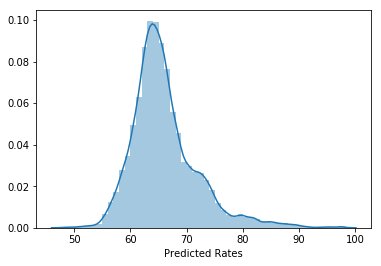

In [35]:
sns_plot = sns.distplot(data1['Predicted Rates'])
fig = sns_plot.get_figure()


In [36]:
mean = statistics.mean(predicted_rates)
std = statistics.stdev(predicted_rates)
med = statistics.median(predicted_rates)

print("mean =",mean,'\nstd =',std,'\nmed =',med, '\nmin =',min (predicted_rates), '\nmax =',max(predicted_rates))

mean = 66.04471160916452 
std = 5.92748915600735 
med = 64.96377251956494 
min = 47.94350003635429 
max = 98.15837390940125


In [37]:
DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,
        st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform, st.johnsonsu,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]


distributions_list = list([
    'alpha','anglit','arcsine','beta','betaprime','bradford','burr','cauchy','chi','chi2','cosine',
    'dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk',
    'foldcauchy','foldnorm','genlogistic','genpareto','gennorm','genexpon',
    'genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r',
    'gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss',
    'invweibull','johnsonsb','johnsonsu','ksone','kstwobign',
    'laplace','levy','levy_l','levy_stable',
    'logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf',
    'nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal',
    'rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda',
    'uniform','johnsonsu','vonmises','vonmises_line','wald','weibull_min','weibull_max','wrapcauchy'
])

df_dist = pd.DataFrame(distributions_list, columns = ['NAMES'], index = range(len(distributions_list)))


months = ['Jan','Feb','March','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec']
df1=pd.DataFrame(months,columns=['Months'],index=range(len(months)))

days = widgets.IntSlider(
    value=1.0,
    min=1.0,
    max=365.0,
    step=1.0,
    description='Days to predict:',
    continuous_update=False
)


use_date = widgets.Checkbox(
    description='Date: ',
    value=True,
)

container = widgets.HBox(children=[use_date, Month])


Month = widgets.Dropdown(
    description='Month',
    value='Jan',
    options=df1['Months'].unique().tolist()
)

textbox = widgets.Dropdown(
    description='Airline:   ',
    value='DL',
    options=df['carrier'].unique().tolist()
)


def validate():
    if Month.value in df1['Months'].unique() and textbox.value in df['carrier'].unique():
        return True
    else:
        return False


def response(change):
        if use_date.value:
            filter_list = [i and j and k for i, j, k in
                           zip(df['month'] == month.value, df['carrier'] == textbox.value,
                               df['origin'] == origin.value)]
            temp_df = df[filter_list]

        else:
            filter_list = [i and j for i, j in
                           zip(df['carrier'] == 'DL', df['origin'] == origin.value)]
            temp_df = df[filter_list]
        x1 = temp_df['arr_delay']
        x2 = temp_df['dep_delay']
        with g.batch_update():
            g.data[0].x = x1
            g.data[1].x = x2
            g.layout.barmode = 'overlay'
            g.layout.xaxis.title = 'Delay in Minutes'
            g.layout.yaxis.title = 'Number of Delays'


days.observe(response, names="value")
use_date.observe(response, names="value")

In [38]:
trace = go.Histogram( x = data1['Predicted Rates'])

layout = {'title':'Frequency distribution of rates',
         'xaxis':{'title':"Rates"},
         'yaxis':{'title':'Frequency'}}

py.offline.iplot({'data':data,'layout':layout})

ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: [1       0.000000
2       0.000450
5       0.005447
6      -0.002978
7      -0.002602
8       0.001795
9       0.001932
12     -0.001979
13      0.005252
14      0.003111
15     -0.001041
16      0.004515
19      0.005740
20      0.006641
21     -0.002597
22      0.005510
23      0.010111
26      0.004260
27      0.002870
28      0.011350
29      0.004147
30      0.003141
33     -0.004458
34     -0.002438
35     -0.005451
36     -0.002135
37     -0.003079
40      0.001277
41     -0.000578
42      0.001947
          ...   
2196   -0.000083
2197   -0.000154
2198   -0.003866
2199   -0.007820
2200    0.001201
2203   -0.002444
2204    0.003221
2205    0.000453
2206    0.002990
2207   -0.002709
2210    0.001456
2211    0.004916
2212    0.001898
2213   -0.001193
2214   -0.001678
2217    0.013568
2218   -0.000229
2219    0.001411
2220    0.007476
2221    0.007397
2224    0.002439
2225   -0.008751
2226   -0.009885
2227    0.007929
2228    0.011103
2231    0.002947
2232   -0.006810
2233   -0.009446
2234    0.008171
2235    0.000718
Name: First_difference, Length: 1565, dtype: float64]

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['area', 'bar', 'barpolar', 'box',
                     'candlestick', 'carpet', 'choropleth',
                     'choroplethmapbox', 'cone', 'contour',
                     'contourcarpet', 'densitymapbox', 'funnel',
                     'funnelarea', 'heatmap', 'heatmapgl',
                     'histogram', 'histogram2d',
                     'histogram2dcontour', 'image', 'indicator',
                     'isosurface', 'mesh3d', 'ohlc', 'parcats',
                     'parcoords', 'pie', 'pointcloud', 'sankey',
                     'scatter', 'scatter3d', 'scattercarpet',
                     'scattergeo', 'scattergl', 'scattermapbox',
                     'scatterpolar', 'scatterpolargl',
                     'scatterternary', 'splom', 'streamtube',
                     'sunburst', 'surface', 'table', 'treemap',
                     'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])